# Assignment 2 - Image Inpainting

Name: Beat Brändli
Matriculation number: 20 - 163 - 226

In [1]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from scipy import sparse
from scipy.signal import convolve2d
import numpy as np
from hessian_matrix import *
from scipy.sparse import diags

## Test Image

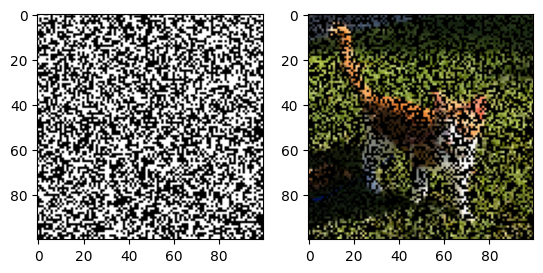

In [2]:
masked_img = np.array(Image.open('masked_cat.png')) / 255
omega = np.array(Image.open('mask.png'))/ 255
g = masked_img
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(omega, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(g)

## hessian_matrix() function

We provide the implementation of the hessian matrix.

input variables: 
- u: your image
- omega: binary mask
- reg: regularization parameter

Example usage:

In [3]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, omega, 1)
U = sparse.triu(A, k=1, format='csr')
A_n_t = A.toarray()


In [4]:
B = hessian_matrix(u_ex, u_ex, 1.)
print(B.toarray())

[[ 4. -2.  0. -2.  0.  0.  0.  0.  0.]
 [-2.  6. -2.  0. -2.  0.  0.  0.  0.]
 [ 0. -2.  4.  0.  0. -2.  0.  0.  0.]
 [-2.  0.  0.  6. -2.  0. -2.  0.  0.]
 [ 0. -2.  0. -2.  8. -2.  0. -2.  0.]
 [ 0.  0. -2.  0. -2.  6.  0.  0. -2.]
 [ 0.  0.  0. -2.  0.  0.  4. -2.  0.]
 [ 0.  0.  0.  0. -2.  0. -2.  6. -2.]
 [ 0.  0.  0.  0.  0. -2.  0. -2.  4.]]


## GRADIENT DESCENT


In [5]:
def GD(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter
    :returns u: inpainted image of size (M, N, 3)
    """
    mask_vector = omega.flatten()
    A = hessian_matrix(g, omega, lmbda)+np.diag(mask_vector*2)
    u=g.copy()
    size_x = g.shape[0]
    size_y = g.shape[1]
    image_array = np.array(u)
    
    step_size = 0.1
    

    image_vector_r = image_array[:,:,0].flatten()
    image_vector_g = image_array[:,:,1].flatten()
    image_vector_b = image_array[:,:,2].flatten()
    image_vector0 = np.column_stack((image_vector_r, image_vector_g, image_vector_b))
    gradient = np.ones(image_vector0.shape)
    
    i=0
    while np.linalg.norm(gradient) > 1e-4 and i<1000:
        for j in range(3):
            # Compute the gradient
            gradient =  -2*mask_vector*(image_array[:,:,j].flatten())+A @ image_vector0[:,j]
            # Gradient descent step
            image_vector0[:,j] = image_vector0[:,j] - step_size * gradient
        i+=1
    u[:,:,0] = image_vector0[:,0].reshape(size_x, size_y)
    u[:,:,1] = image_vector0[:,1].reshape(size_x, size_y)
    u[:,:,2] = image_vector0[:,2].reshape(size_x, size_y)
    return u

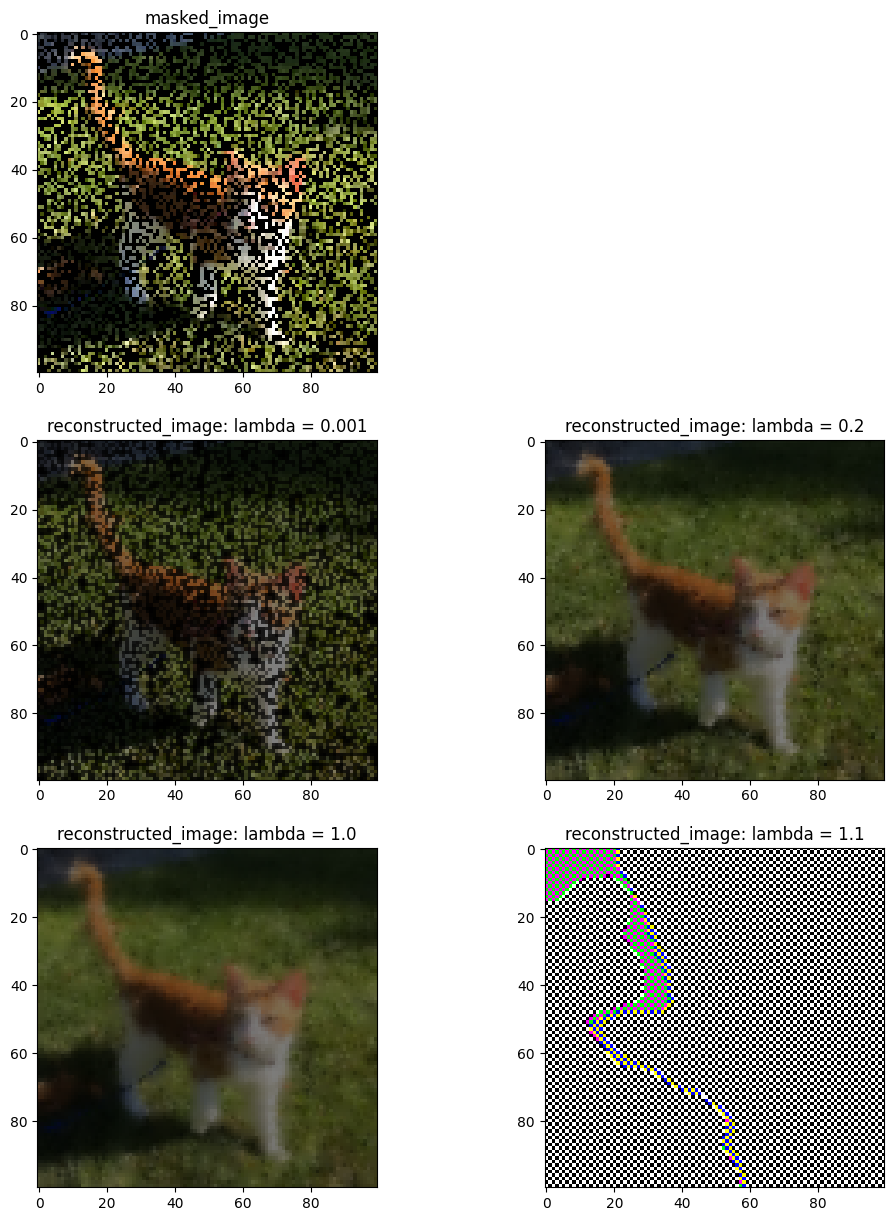

In [6]:
# run gradient descent algorithm
inpainted_img_gd_small = GD(g, omega, 0.001)
inpainted_img_gd_reasonable = GD(g, omega, 0.4)
inpainted_img_gd_big = GD(g, omega, 1.0)
inpainted_img_gd_too_big = GD(g, omega, 1.1)

# for visualization purpose 
inpainted_img_gd_small = np.clip(inpainted_img_gd_small, 0, 1)
inpainted_img_gd_reasonable = np.clip(inpainted_img_gd_reasonable, 0, 1)
inpainted_img_gd_big = np.clip(inpainted_img_gd_big, 0, 1)
inpainted_img_gd_too_big = np.clip(inpainted_img_gd_too_big, 0, 1)


plt.figure(figsize=(12, 15))
ax1 = plt.subplot(3, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(3,2, 3)
plt.imshow(inpainted_img_gd_small)
ax3 = plt.subplot(3,2, 4)
plt.imshow(inpainted_img_gd_reasonable)
ax4 = plt.subplot(3,2, 5)
plt.imshow(inpainted_img_gd_big)
ax5 = plt.subplot(3,2, 6)
plt.imshow(inpainted_img_gd_too_big)


ax1.set_title("masked_image")
ax2.set_title("reconstructed_image: lambda = 0.001")
ax3.set_title("reconstructed_image: lambda = 0.2")
ax4.set_title("reconstructed_image: lambda = 1.0")
ax5.set_title("reconstructed_image: lambda = 1.1")
plt.show()

### Lambda = 0.001
The regularisation term has no weight. Therefore we do not add no additional information to the energy function. This results in the original image, because the gradent is zero.

### Lambda = 0.2
The regularisation term and the data term are now well balanced. The gradient descent tries to create a smooth (because of the regularization term) image that is similar to the original image (because of the data term).

### Lambda = 1
The regularisation term now has more weight. Therefore the image gets smoother.

### Lambda = 2
The regularisation term has even more weight. Every gradient descent step tries to smooth the image even more. Because the data term still has a small impact, the gradient descent stops at a local minima. In the resulting image, there are are rectangles with the same color. So the image is locally smooth. The image is not further smoothed because the data term stops the gradient descent at a local minima.  
If the lambda value is increased even more, the image would be even smoother. If the lambda is enough high, the image is only white.

## GAUSS - SEIDEL

In [7]:
def LGS(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter
    :returns u: inpainted image of size (M, N, 3)
    """
    image_array = np.array(g)
    u = image_array.copy()
    
    mask_vector = omega.flatten()
    A = hessian_matrix(g, omega, lmbda)+diags(mask_vector*2, offsets=0, format='csr')
    diag = np.diag(A.toarray())
    U = sparse.triu(A, k=1, format='csr')
    L = sparse.tril(A, k=1, format='csr')
    
    size_x = g.shape[0]
    size_y = g.shape[1]

    # Create the vectors for every color at time t
    u_t_r = image_array[:,:,0].flatten().copy()
    b_r = 2*mask_vector*image_array[:,:,0].flatten().copy()
    u_t_g = image_array[:,:,1].flatten().copy()
    b_g = 2*mask_vector*image_array[:,:,1].flatten().copy()
    u_t_b = image_array[:,:,2].flatten().copy()
    b_b = 2*mask_vector*image_array[:,:,2].flatten().copy()
    for it in range(20):
        # Create vectors for every color at time t+1
        u_t1_r = np.zeros_like(u_t_r)
        u_t1_g = np.zeros_like(u_t_g)
        u_t1_b = np.zeros_like(u_t_b)
        for i in range(size_x*size_y):
            # Gauss Seidel step for every color
            u_t1_r[i] = (b_r[i] - (L[i,:]@u_t1_r)[0] - (U[i,:]@u_t_r)[0]) / diag[i]
            u_t1_g[i] = (b_g[i] - (L[i,:]@u_t1_g)[0] - (U[i,:]@u_t_g)[0]) / diag[i]
            u_t1_b[i] = (b_b[i] - (L[i,:]@u_t1_b)[0] - (U[i,:]@u_t_b)[0]) / diag[i]
        # Stop iteration if changes get too small
        if ((np.linalg.norm(u_t1_r - u_t_r)+np.linalg.norm(u_t1_g - u_t_g)+np.linalg.norm(u_t1_b - u_t_b))/3) < 0.1:
            u_t_r = u_t1_r.copy()
            u_t_g = u_t1_g.copy()
            u_t_b = u_t1_b.copy()
            break
        u_t_r = u_t1_r.copy()
        u_t_g = u_t1_g.copy()
        u_t_b = u_t1_b.copy()
        

    u[:,:,0] = u_t_r.reshape(size_x, size_y)
    u[:,:,1] = u_t_g.reshape(size_x, size_y)
    u[:,:,2] = u_t_b.reshape(size_x, size_y)
    return u

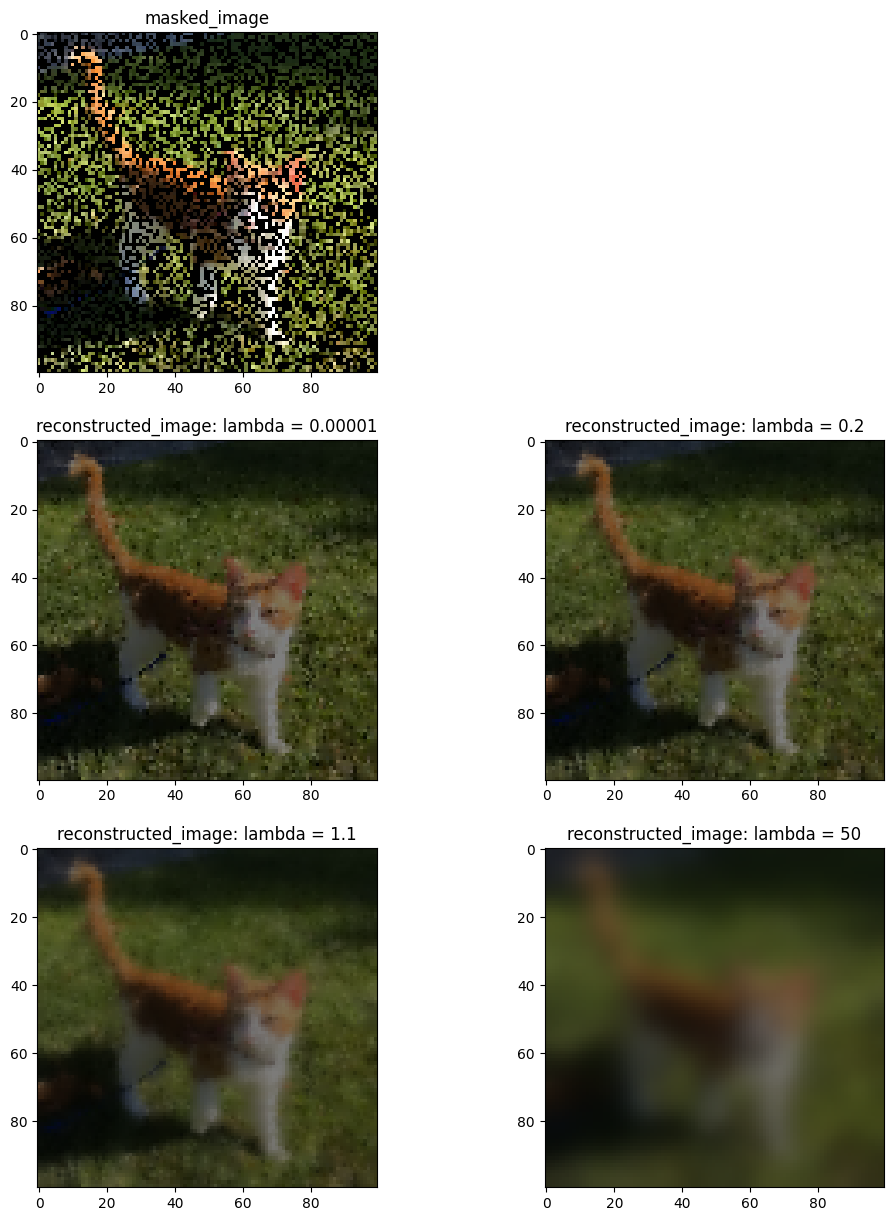

In [8]:
masked_img = np.array(Image.open('masked_cat.png')) / 255
omega = np.array(Image.open('mask.png'))/ 255
g = masked_img.copy()

# run LGS algorithm
inpainted_img_LGS_small = LGS(g, omega, 0.00001)
inpainted_img_LGS_reasonable = LGS(g, omega, 0.2)
inpainted_img_LGS_big = LGS(g, omega, 1.1)
inpainted_img_LGS_too_big = LGS(g, omega, 50)

# for visualization purpose 
inpainted_img_LGS_small = np.clip(inpainted_img_LGS_small, 0, 1)
inpainted_img_LGS_reasonable = np.clip(inpainted_img_LGS_reasonable, 0, 1)
inpainted_img_LGS_big = np.clip(inpainted_img_LGS_big, 0, 1)
inpainted_img_LGS_too_big = np.clip(inpainted_img_LGS_too_big, 0, 1)


plt.figure(figsize=(12, 15))
ax1 = plt.subplot(3, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(3,2, 3)
plt.imshow(inpainted_img_LGS_small)
ax3 = plt.subplot(3,2, 4)
plt.imshow(inpainted_img_LGS_reasonable)
ax4 = plt.subplot(3,2, 5)
plt.imshow(inpainted_img_LGS_big)
ax5 = plt.subplot(3,2, 6)
plt.imshow(inpainted_img_LGS_too_big)


ax1.set_title("masked_image")
ax2.set_title("reconstructed_image: lambda = 0.00001")
ax3.set_title("reconstructed_image: lambda = 0.2")
ax4.set_title("reconstructed_image: lambda = 1.1")
ax5.set_title("reconstructed_image: lambda = 50")
plt.show()

### Lambda = 0.00001
The regularisation term has a small weight. Therefore is only smoothed a little bit, because the enegry function is mainly determined by the data term.

### Lambda = 0.2
The regularisation term and the data term are now well balanced. The gradient descent tries to create a smooth (because of the regularization term) image that is similar to the original image (because of the data term). This or the next lambda seem to be reasonable values. This one is a bit sharper than the next one, but also has more noise.

### Lambda = 1
The regularisation term now has more weight. Therefore the image gets smoother.

### Lambda = 50
The regularisation term has now a very high weight. The resulting image is very smooth. It is interesting to see, that the image gets darker.


## Conclusion
Compared to the gradient descent, the gauss-seidel method is much more stable. Even with a very small lambda, the minimization still works. The same is true for a small lambda. The gradient descent already is kind of unstable at a lambda = 2 wereas gauss seidel still works at lambda = 50.

####################################################################################################################

I also created an implementation with the inverse of the matrix. As expected it is way slower than the other implementation. Instead it is faster. The resulting images are the same.

In [9]:
def LGS_inv(g, omega, lmbda):
    """
    g: color image of size (M, N, 3)
    omega: mask of size (M, N)
    lmbda: regularization parameter
    :returns u: inpainted image of size (M, N, 3)
    """
    image_array = np.array(g)
    u = image_array.copy()
    mask_vector = omega.flatten()
    A = hessian_matrix(g, omega, lmbda)+diags(mask_vector*2, offsets=0, format='csr')
    U = sparse.triu(A, k=1, format='csc')
    L = sparse.tril(A, k=0, format='csc')
    L_inv = sparse.linalg.inv(L)
    
    size_x = g.shape[0]
    size_y = g.shape[1]
    image_vector_r = image_array[:,:,0].flatten()
    image_vector_g = image_array[:,:,1].flatten()
    image_vector_b = image_array[:,:,2].flatten()

    b_r= 2*mask_vector*u[:,:,0].flatten()
    b_g= 2*mask_vector*u[:,:,1].flatten()
    b_b= 2*mask_vector*u[:,:,2].flatten()
    for i in range(10):

        image_vector_r = L_inv@(b_r - U@image_vector_r)
        image_vector_g = L_inv@(b_g - U@image_vector_g)
        image_vector_b = L_inv@(b_b - U@image_vector_b)

        image_array[:,:,0] = image_vector_r.reshape(size_x, size_y)
        image_array[:,:,1] = image_vector_g.reshape(size_x, size_y)
        image_array[:,:,2] = image_vector_b.reshape(size_x, size_y)

    return image_array

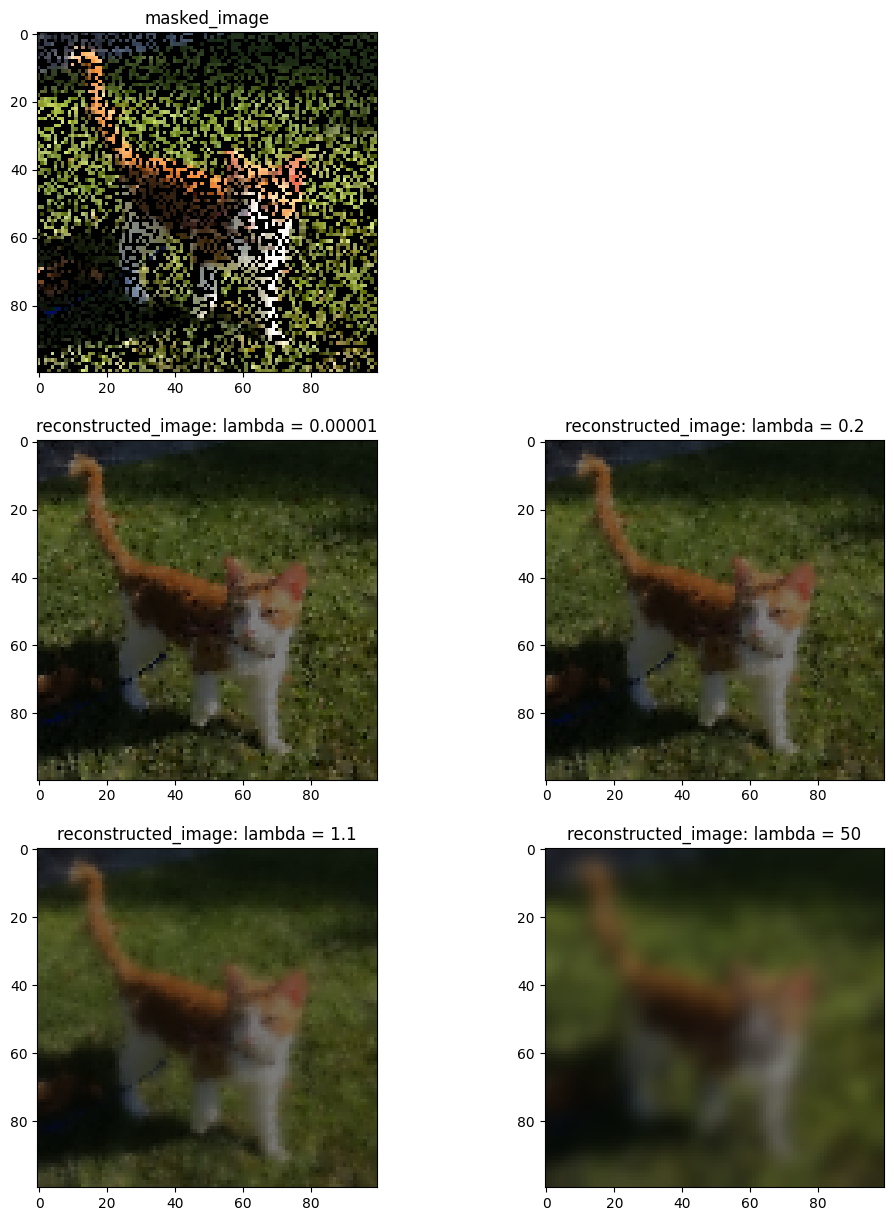

In [10]:
masked_img = np.array(Image.open('masked_cat.png')) / 255
omega = np.array(Image.open('mask.png'))/ 255
g = masked_img.copy()

# run LGS algorithm
inpainted_img_LGS_small = LGS_inv(g, omega, 0.00001)
inpainted_img_LGS_reasonable = LGS_inv(g, omega, 0.2)
inpainted_img_LGS_big = LGS_inv(g, omega, 1.1)
inpainted_img_LGS_too_big = LGS_inv(g, omega, 50)

# for visualization purpose 
inpainted_img_LGS_small = np.clip(inpainted_img_LGS_small, 0, 1)
inpainted_img_LGS_reasonable = np.clip(inpainted_img_LGS_reasonable, 0, 1)
inpainted_img_LGS_big = np.clip(inpainted_img_LGS_big, 0, 1)
inpainted_img_LGS_too_big = np.clip(inpainted_img_LGS_too_big, 0, 1)


plt.figure(figsize=(12, 15))
ax1 = plt.subplot(3, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(3,2, 3)
plt.imshow(inpainted_img_LGS_small)
ax3 = plt.subplot(3,2, 4)
plt.imshow(inpainted_img_LGS_reasonable)
ax4 = plt.subplot(3,2, 5)
plt.imshow(inpainted_img_LGS_big)
ax5 = plt.subplot(3,2, 6)
plt.imshow(inpainted_img_LGS_too_big)


ax1.set_title("masked_image")
ax2.set_title("reconstructed_image: lambda = 0.00001")
ax3.set_title("reconstructed_image: lambda = 0.2")
ax4.set_title("reconstructed_image: lambda = 1.1")
ax5.set_title("reconstructed_image: lambda = 50")
plt.show()

###############################################################################################  

# Theoretical Exercise

Energy Equation:  
$
E[u_C] = | u_C - g_C |_{\Omega}^2 + \lambda | \nabla u_C |_{2,1}^2
$

Data Term:  
$
| u_C - g_C |_{\Omega}^2 = \sum_{i,j} \Omega[i,j] \left( u_C[i,j] - g_C[i,j]\right)^2
$

Regularization Term:  
$
|\nabla u_C|_{2,1}^2 = \sum_{i,j} |\nabla u_C[i,j]|_2^2 
= \sum_{i,j} (u_C[i+1,j] - u_C[i,j])^2 + (u_C[i,j+1] - u_C[i,j])^2
$

Gradient of the Data Term:  
$
\nabla | u_C - g |_{\Omega}^2 = 2 \Omega \left( u_C - g_C \right) = 2 \Omega u_C - 2 \Omega g_C
$


Calculate the gradient of the regularization term is a bit more complicated. Especially at the boundaries.  
Therefore I caclulated the gradient of the regularization term for a corner, an edge and a pixel in the middle of the image. I start counting at 1. So the pixel in the top left corner is (1,1)
<br>
i=1, j=1:  
$
\frac{d}{du_c[1,1]} \sum_{i,j} |\nabla u_c[i,j]|_2^2 = \frac{d}{du_c[1,1]} (u_c[2,1]-u_c[1,1])^2 + (u_c[1,2]-u_c[1,1])^2
= -2(u_c[2,1]-u_c[1,1]) - 2(u_c[1,2]-u_c[1,1]) \\=  4 u_c[1,1]-2 u_c[2,1] -2 u_c[1,2]
$  
<br>
Case $i=1,j \neq 1,n,m$  
$
\frac{d}{du_c[0,j]} \sum_{i,j} |\nabla u_C[i,j]|_2^2 = \frac{d}{du_c[1,j]} (u_c[2,j]-u_c[1,j])^2 + (u_c[1,j+1]-u_c[1,j])^2 + (u_c[1,j]-u_c[1,j-1])^2\\
= 2 u_c[1,j] - 2 u_c[2,j] + 2 u_c[1,j] - 2 u_c[1,j+1] + 2 u_c[1,j]  - 2u_c[1,j-1]\\
= 6 u_c[1,j] - 2 u_c[2,j] - 2 u_c[1,j+1] - 2 u_c[1,j-1]
$  
<br>
Case $i,j \neq 1,n,m$  
$
\frac{d}{du_c[i,j]} \sum_{i,j} |\nabla u_C[i,j]|_2^2 = \frac{d}{du_c[i,j]} (u_c[i+1,j]-u_c[i,j])^2 + (u_c[i,j+1]-u_c[i,j])^2 + (u_c[i,j]-u_c[i-1,j])^2 + (u_c[i,j]-u_c[i,j-1])^2\\
= 2 u_c[i,j] - 2 u_c[i+1,j] + 2 u_c[i,j] - 2 u_c[i,j+1] + 2 u_c[i,j]  - 2u_c[i-1,j] + 2u_c[i,j] -2u_c[j-1]\\
= 8 u_c[i,j] - 2 u_c[i+1,j] - 2 u_c[i-1,j] - 2 u_c[i,j+1] - 2 u_c[i,j-1]
$  
<br>
Therefore the gradient of the regularisation term can be written as:
$
\nabla | u_c - g |_{\Omega}^2 = A u
$  
Where A is a n+m x n+m matrix and u is the image written as a vector.  
The matrix A looks like this for  a 4x4 image:  
$$\begin{bmatrix}
\textcolor{red}{4} & \textcolor{red}{-2} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{-2} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} \\
\textcolor{green}{-2} & \textcolor{green}{6} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} \\
\textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{6} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} \\
\textcolor{red}{4} & \textcolor{red}{0} & \textcolor{red}{-2} & \textcolor{red}{4} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{-2} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} \\
\textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{6} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} \\
0 & -2 & 0 & 0 & -2 & 8 & -2 & 0 & 0 & -2 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -2 & 0 & 0 & -2 & 8 & -2 & 0 & 0 & -2 & 0 & 0 & 0 & 0 & 0 \\
\textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{6} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} \\
\textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{6} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} \\
0 & 0 & 0 & 0 & 0 & -2 & 0 & 0 & -2 & 8 & -2 & 0 & 0 & -2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -2 & 0 & 0 & -2 & 8 & -2 & 0 & 0 & -2 & 0 \\
\textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{6} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} \\
\textcolor{red}{4} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{-2} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{4} & \textcolor{red}{-2} & \textcolor{red}{0} & \textcolor{red}{0} \\
\textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{6} & \textcolor{green}{-2} & \textcolor{green}{0} \\
\textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{0} & \textcolor{green}{0} & \textcolor{green}{-2} & \textcolor{green}{6} & \textcolor{green}{-2} \\
\textcolor{red}{4} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{-2} & \textcolor{red}{0} & \textcolor{red}{0} & \textcolor{red}{-2} & \textcolor{red}{4} \\
\end{bmatrix}$$


All the red lines represent corners in the image. All the green lines represent edges in the image. All the white lines represent pixels in the middle of the image. 

This results in the following 3 gradient equations:  
<br>
Corner:  
$
\nabla E[u_c[1,1]] = 2 \Omega[1,1] u_c[1,1] - 2 \Omega[1,1] g_c[1,1] +  \lambda (4 u_c[1,1]-2 u_c[2,1] -2 u_c[1,2])
$
<br>
Edge:  
$
\nabla E[u_c[1,j]] = 2 \Omega[1,j] u_c[1,j] - 2 \Omega[1,j] g_c[1,j] +  \lambda (6 u_c[1,j] - 2 u_c[2,j] - 2 u_c[1,j+1] - 2 u_c[1,j-1])
$
<br>
Middle:  
$
\nabla E[u_c[i,j]] = 2 \Omega[i,j] u_c[i,j] - 2 \Omega[i,j] g_c[i,j] +  \lambda (8 u_c[i,j] - 2 u_c[i+1,j] - 2 u_c[i-1,j] - 2 u_c[i,j+1] - 2 u_c[i,j-1])
$  
Here I just listed one corner and one edge. The other corners and edges can be calculated in the same way. The indicies just have to be changed accordingly.
